<a href="https://colab.research.google.com/github/SudeepSarkar/Computer-Vision-Course/blob/main/Lecture_10_2D_Linear_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2D Linear Estimation of Transformations

# Some Conventions

We will use the following notation to generically represent these transformations.

\begin{equation}
    f (\widetilde{\mathbf{x_i}}; \mathbf{p})
\end{equation}

where $\mathbf{p}$ is the set of parameters to be estimated.
    
For numerical convenience of choosing initialization, we usually reparameterize the transformations so that **when the parameters, $\mathbf{p}$, are all zero, the point does not move**. To achieve this we add a 1 to the first two diagonal values of the transformation matrix. See Table 6.1

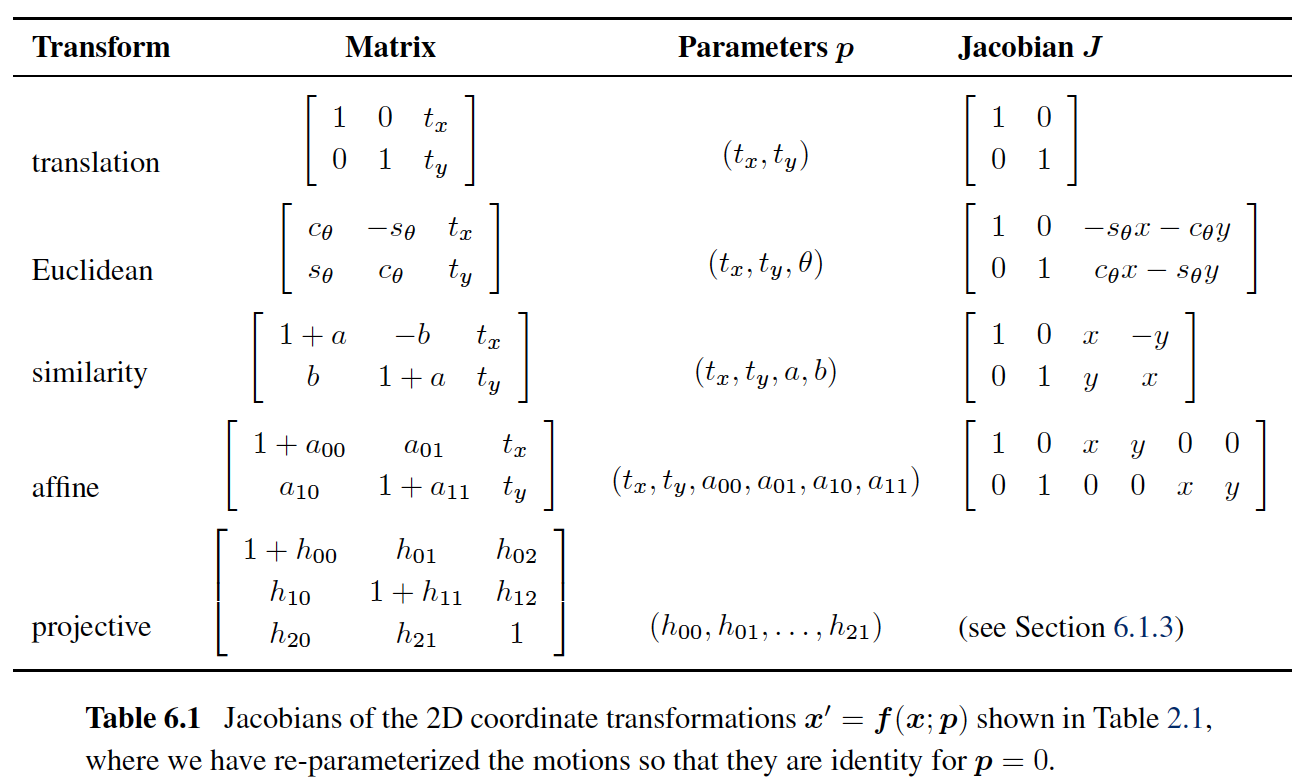

# Starting point - corresponding points

The starting point of the estimation are corresponding pairs of points between two images. There are many ways to computing these corresponding pairs. Here we use the OpenCV solution using SIFT features and descriptors, which works well in many circumstances.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/Colab\ Notebooks/data/

Mounted at /content/drive
'Armes 1.png'   house_1.png	   lizard.jpg		 mountain_peak_2.png
'Armes 2.png'   house_2.png	   MOT16-08-raw.webm	 window_1.png
 hawaii.png     house_facade.png   mountain_peak_1.png	 window_2.png


In [167]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import scipy.ndimage as scimage
import torch.nn as nn

!pip install opencv-contrib-python==4.4.0.44
import cv2
print (cv2 .__version__)


np.set_printoptions(precision=2, suppress=True)

4.4.0


Input image size: (269, 1200)


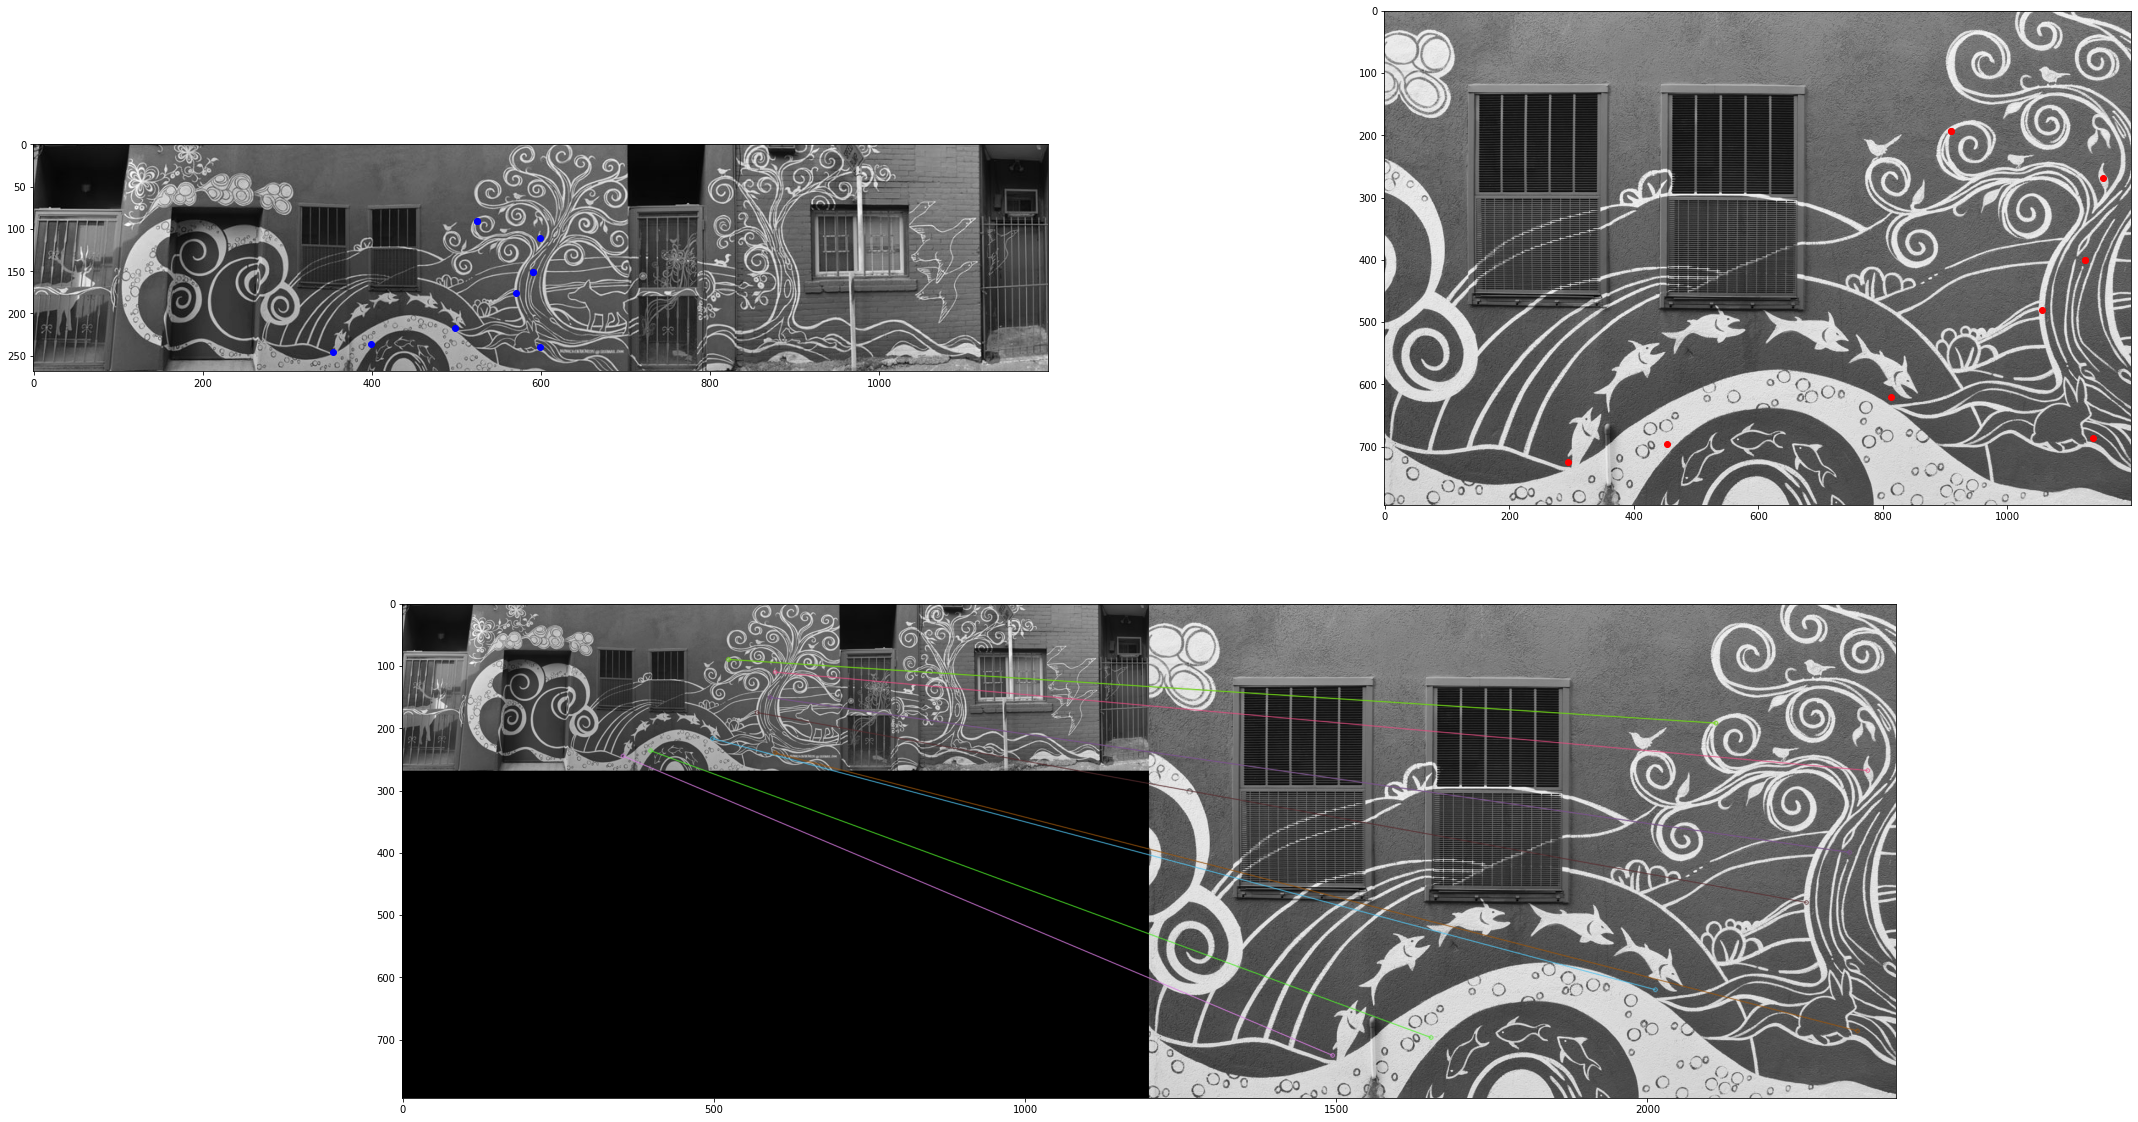

In [176]:
#image_1 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/data/parking_lot_meva_1.png')
#image_2 = cv2.imread('/content/drive/MyDrive/Colab Notebooks/data/parking_lot_meva_3.png')

from skimage import io

image_1 = io.imread('http://mcfcrandall.files.wordpress.com/2015/11/blog_danforth_monica_mural_panorama.jpg')
image_2 = io.imread('http://mcfcrandall.files.wordpress.com/2015/11/blog_monica_mural_fish_tree_windows1.jpg')
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)

 
#image_1 = cv2.imread('http://mcfcrandall.files.wordpress.com/2015/11/blog_danforth_monica_mural_panorama.jpg')
#image_2 = cv2.imread('http://mcfcrandall.files.wordpress.com/2015/11/blog_monica_mural_fish_tree_windows1.jpg')


image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2GRAY)
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2GRAY)
print("Input image size:", image_1.shape)

sift = cv2.SIFT_create(nOctaveLayers = 3, contrastThreshold = 0.04, edgeThreshold = 10, sigma = 1.6)

keypoints_1, descriptors_1 = sift.detectAndCompute(image_1, None)
keypoints_2, descriptors_2 = sift.detectAndCompute(image_2, None)

# FEATURE MATCHING
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1, descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)
X_1 = []
X_2 = []
for i in range(10) :
    X_1.append([keypoints_1[matches[i].queryIdx].pt[0], keypoints_1[matches[i].queryIdx].pt[1]])
    X_2.append([keypoints_2[matches[i].trainIdx].pt[0], keypoints_2[matches[i].trainIdx].pt[1]])
X_1 = np.array(X_1)
X_2 = np.array(X_2)
#----------------------------------Display-------------------------------------------------------
# draw matches
match_image = cv2.drawMatches(image_1, keypoints_1, image_2, keypoints_2, matches[:10], image_2, flags=2)

plt.figure(figsize=(40,20))
plt.subplot(221)
plt.imshow(image_1, 'gray')
plt.plot(X_1[:,0], X_1[:,1], 'bo')
plt.subplot(222)
plt.imshow(image_2, 'gray')
plt.plot(X_2[:,0], X_2[:,1], 'ro')
plt.subplot(212)
plt.imshow(match_image)

# save the image
# cv2.imwrite("table-sift.jpg", sift_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


# 2D affine alignment

Given a set of corresponding points between two 2D patches, $\{(\widetilde{\mathbf{x_i}}', \widetilde{\mathbf{x_i}})|i=1, \cdots n\}$ find the transformation between them. We will first consider the affine transformation, which is** linear with respect to the parameters**. Note this concept of linearity is different from the transformation being linear. All the geometric transformations we have studied are linear.
    
We have three points to consider: the initial point $\widetilde{\mathbf{x_i}}$, the transformed point using the transformation, $f (\widetilde{\mathbf{x_i}}; \mathbf{p})$, and the final point, $\widetilde{\mathbf{x_i}}'$. 

We have two differences, as depicted below, $(\widetilde{\mathbf{x_i}}' -\widetilde{\mathbf{x_i}})$, the **disparity** between the points being matched, and the **residual error **of the transformation, $(f (\widetilde{\mathbf{x_i}}; \mathbf{p}) - \mathbf{x_i'}) $. We want to find a transformation $f$ such as the residual error is minimized. 

We next derive an expression that related the residual error with the disparity *for one point*. We will then sum this quantity over all the points to arrive at the total residual.
    

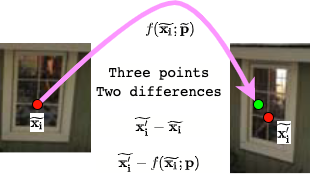

The residual (the error) of the $i$-th points is given by 

\begin{eqnarray}
    \mathbf{r}_i & = & f (\widetilde{\mathbf{x_i}}; \mathbf{p}) - \widetilde {\mathbf{x_i}}^{'}\\
    & = & \begin{bmatrix}
        a_{00}+1 & a_{01} & t_x \\
        a_{10} & a_{11} + 1 & t_y \\
        0  & 0 & 1
    \end{bmatrix} \begin{bmatrix}
        x_i \\ y_i \\ 1
    \end{bmatrix} - \begin{bmatrix}
        x_i' \\ y_i' \\ 1
    \end{bmatrix}\\
    & = & \left ( \begin{bmatrix}
        a_{00} & a_{01} & t_x \\
        a_{10} & a_{11} & t_y \\
        0  & 0 & 0
    \end{bmatrix} + \begin{bmatrix}
        1 & 0 & 0 \\
        0 & 1 & 0 \\
        0  & 0 & 1
    \end{bmatrix} \right ) \begin{bmatrix}
        x_i \\ y_i \\ 1
    \end{bmatrix} - \begin{bmatrix}
        \hat{x}_i' \\ y_i' \\ 1
    \end{bmatrix}\\
    & = & 
    \begin{bmatrix}
        a_{00} & a_{01} & t_x \\
        a_{10} & a_{11} & t_y \\
        0  & 0 & 0
    \end{bmatrix} 
    \begin{bmatrix}
        x_i \\ y_i \\ 1
    \end{bmatrix}  - 
    \begin{bmatrix}
        x_i' - x_i\\ y_i' - y_i \\ 0
    \end{bmatrix} \\
        & = & 
    \begin{bmatrix}
        a_{00} & a_{01} & t_x \\
        a_{10} & a_{11} & t_y 
    \end{bmatrix} 
    \begin{bmatrix}
        x_i \\ y_i 
    \end{bmatrix}  - 
    \begin{bmatrix}
        x_i' - x_i\\ y_i' - y_i 
    \end{bmatrix} \\
\end{eqnarray}
\begin{eqnarray}
    \mathbf{r}_i^{2 \times 1}  & = & 
    \begin{bmatrix}
        1 & 0 & x_i & y_i & 0 & 0 \\
        0 & 1 & 0   & 0   & x_i & y_i 
    \end{bmatrix}
    \begin{bmatrix}
        t_x \\ t_y \\ a_{00} \\ a_{01} \\ a_{10} \\ a_{11} 
    \end{bmatrix}  - 
    \begin{bmatrix}
        x_i' - x_i\\ y_i' - y_i 
    \end{bmatrix} \\
        & = & J(\mathbf{x_i}) \mathbf{p} - \Delta \mathbf{x_i}
\end{eqnarray}

Note that $\Delta \mathbf{x_i} = (\mathbf{x_i}' - \mathbf{x_i})$ is the difference between initial and new point. 

# Jacobian

The quantity Jacobian is named are [Carl Gustav Jacob Jacobi](https://en.wikipedia.org/wiki/Carl_Gustav_Jacob_Jacobi).

The term $J(\mathbf{x_i})$ is called the Jacobian and is the derivative of the function being optimized $f (\widetilde{\mathbf{x_i}}; \mathbf{p})$ with respect to the parameters being estimated, $\mathbf{p}$. It is a matrix of first derivatives, which for the example at hand is as indicated below. You should derive the derivatives yourself and be convinced that they are as indicated.

\begin{eqnarray}
    \frac{\partial}{\partial \mathbf{p}} f (\widetilde{\mathbf{x_i}}; \mathbf{p}) & = & 
\begin{bmatrix}
    \frac{\partial f_x}{ \partial p_0}  &  \frac{\partial f_x}{ \partial p_1}  &\cdots & \frac{\partial f_x}{ \partial p_n}   \\
    \frac{\partial f_y}{ \partial p_0} & \frac{\partial f_x}{ \partial p_1}  & \cdots & \frac{\partial f_y}{ \partial p_n}   \\
\end{bmatrix} \\
    & = & 
\begin{bmatrix}
    1 & 0 & x_i & y_i & 0 & 0 \\
    0 & 1 & 0   & 0   & x_i & y_i 
\end{bmatrix}
\end{eqnarray}

Note that the components of the Jacobian do not involve the parameters being estimated. Because of this property, we would be able to solve this particular problem in a non-iterative fashion, i.e. there is a closed form expression of the solution.

# Total residual

The total error is given by sum of the squared resiudals, which is the L2 norm.  Note that are other possible forms for the total error, such as sum of absolute values of the residual (L1 norm), or weighted L2 norms (robust estimators). 

\begin{eqnarray}
    r & = & \sum_i || \mathbf{r}_i||^2 \\
    & = & \sum_i \mathbf{r}_i^T \mathbf{r}_i = \sum_i \begin{bmatrix}
        - & -
    \end{bmatrix}\begin{bmatrix}
        - \\ -
    \end{bmatrix} \\
    & = & \sum_i \left ( J(\mathbf{x_i}) \mathbf{p} - \Delta \mathbf{x_i} \right )^T \left ( J(\mathbf{x_i}) \mathbf{p} - \Delta \mathbf{x_i} \right ) \\
    & = & \sum_i \left ( \mathbf{p}^T J(\mathbf{x_i})^T - \Delta \mathbf{x_i}^T \right ) \left ( J(\mathbf{x_i}) \mathbf{p} - \Delta \mathbf{x_i} \right ) \\
    & = & \sum_i \mathbf{p}^T J(\mathbf{x_i})^T J(\mathbf{x_i}) \mathbf{p} - 2 \mathbf{p}^T J(\mathbf{x_i})^T \Delta \mathbf{x_i} + \Delta \mathbf{x_i}^T \Delta \mathbf{x_i} \\
    & = & \mathbf{p}^T \left ( \sum_i  J(\mathbf{x_i})^T J(\mathbf{x_i}) \right) \mathbf{p} - 2 \mathbf{p}^T \left ( \sum_i J(\mathbf{x_i})^T \Delta \mathbf{x_i}\right )  + \sum_i \Delta \mathbf{x_i}^T \Delta \mathbf{x_i} \\
     & & \\
    & = & \color{red}{\mathbf{p}^T \mathbf{A}^{6 \times 6} \mathbf{p} - 2 \mathbf{p}^T \mathbf{b}^{6 \times 1}  + c} \\
    & = & \begin{bmatrix}
        ? & ? & ? & ? & ? & ? \\
    \end{bmatrix}
    \begin{bmatrix}
        - & - & - & - & - & - \\
        - & - & - & - & - & - \\
        - & - & - & - & - & - \\
        - & - & - & - & - & - \\
        - & - & - & - & - & - \\
        - & - & - & - & - & - 
    \end{bmatrix}
    \begin{bmatrix}
        ? \\ ? \\ ? \\ ? \\ ? \\ ? 
    \end{bmatrix}  \\
    &  & - 2 \begin{bmatrix}
        - & - & - & - & - & - \\
    \end{bmatrix}
    \begin{bmatrix}
            ? \\ ? \\ ? \\ ? \\ ? \\ ? 
    \end{bmatrix} + \begin{bmatrix}
        -
    \end{bmatrix}
\end{eqnarray}

# Hessian

The quantity Hessian is named after [Otto Hesse](https://en.wikipedia.org/wiki/Otto_Hesse).

"In mathematics, the Hessian matrix or Hessian is a square matrix of **second-order partial derivatives** of a scalar-valued function, or scalar field. It describes the **local curvature of a function **of many variables." For more see the [Wikipedia](https://en.wikipedia.org/wiki/Hessian_matrix) page.

The second-order partial derivatives of our optimized quantity is the matrix $\mathbf{A}$, which is the Hessian for this problem:

\begin{eqnarray}
    \mathbf{A} & = & \sum_i  J(\mathbf{x_i})^T J(\mathbf{x_i}) \\
    & = & \sum_i \begin{bmatrix}
        1 & 0 \\
        0 & 1 \\
        x_i & 0 \\
        y_i & 0 \\
        0 & x_i \\
        0 & y_i
        \end{bmatrix} \begin{bmatrix}
        1 & 0 & x_i & y_i & 0 & 0 \\
        0 & 1 & 0   & 0   & x_i & y_i 
        \end{bmatrix} \\
    & = & \sum_i \begin{bmatrix}
    1 & 0 & x_i & y_i & 0 & 0 \\
    0 & 1 & 0 & 0 & x_i & y_i \\
    x_i & 0 & x_i^2 & x_i y_i & 0 & 0 \\
    y_i & 0 & x_i y_i & y_i^2 & 0 & 0 \\
    0 & x_i & 0 & 0 & x_i^2 & x_i y_i\\
    0 & y_i & 0 & 0 & x_i y_i & y_i^2
    \end{bmatrix} \\
    & = &
    \begin{bmatrix}
    N & 0 & \sum_i x_i & \sum_i y_i & 0 & 0 \\
    0 & 1 & 0 & 0 & \sum_i x_i & \sum_i y_i \\
    \sum_i x_i & 0 & \sum_i x_i^2 & \sum_i x_i y_i & 0 & 0 \\
    \sum_iy_i & 0 & \sum_i x_i y_i & \sum_i y_i^2 & 0 & 0 \\
    0 & \sum_i x_i & 0 & 0 & \sum_i x_i^2 & \sum_i x_i y_i\\
    0 & \sum_i y_i & 0 & 0 & \sum_i x_i y_i & \sum_i y_i^2
    \end{bmatrix}
\end{eqnarray}
    

\begin{eqnarray}
    \mathbf{b} & = &  \sum_i J(\mathbf{x_i})^T \Delta \mathbf{x_i} \\
    & = & \sum_i 
    \begin{bmatrix}
        1 & 0 \\
        0 & 1 \\
        x_i & 0 \\
        y_i & 0 \\
        0 & x_i \\
        0 & y_i
    \end{bmatrix} 
    \begin{bmatrix}
        \Delta x_i \\ \Delta y_i
    \end{bmatrix} \\
    & = & 
    \begin{bmatrix}
        \sum_i \Delta x_i \\
        \sum_i \Delta y_i \\
        \sum_i x_i \Delta x_i \\
        \sum_i y_i \Delta x_i \\
        \sum_i x_i \Delta y_i \\
        \sum_i y_i \Delta y_i \\
    \end{bmatrix}
\end{eqnarray}

# Computation of Hessian using matrix operations

The above Hessian, $\mathbf{A}$, and the vector $\mathbf{b}$  can be computed entirely using matrix operations as follows:

Let the corresponding pairs of points be stored the two matrices as shown below. The corresponding columns in the two matrices store the corresponding pairs of points.

\begin{equation}
\mathbf{X} = \begin{bmatrix}
    x_1 & x_2 & \cdots & x_N \\
    y_1 & y_2 & \cdots & y_N \\
    1   &  1  & \cdots & 1 
\end{bmatrix},  \mathbf{X'} = \begin{bmatrix}
    x_1' & x_2' & \cdots & x_N' \\
    y_1' & y_2' & \cdots & y_N' \\
    1   &  1  & \cdots & 1 
\end{bmatrix}
\end{equation}

The displacement between the corresponding points are stored in the following matrix. Note we ignore the third row of ones.

\begin{eqnarray}
    \Delta \mathbf{Z}^{2 \times N} & = & 
    \begin{bmatrix}
        1 & 0 & 0 \\
        0 & 1 & 0
    \end{bmatrix}
    \left (\mathbf{X'} - \mathbf{X} \right) \\
    \Delta \mathbf{X}^{2N \times 1} & = & \texttt{row scan into vector} ( \Delta \mathbf{Z})
\end{eqnarray}

Two constant matrices below are used to select coordinates from the point above to create the Jacobian

\begin{equation}
\mathbf{P_1} = \begin{bmatrix}
    0 & 0 & 1 & 0 & 0 & 0\\
    0 & 0 & 0 & 1 & 0 & 0\\
    1 & 0 & 0 & 0 & 0 & 0
\end{bmatrix},
\mathbf{P_2} = \begin{bmatrix}
    0 & 0 & 0 & 0 & 1 & 0\\
    0 & 0 & 0 & 0 & 0 & 1 \\
    0 & 1 & 0 & 0 & 0 & 0 
\end{bmatrix} 
\end{equation}

\begin{equation}
\mathbf{J_1} =  \mathbf{X}^T \mathbf{P_1}   =  \begin{bmatrix}
    1 & 0 & x_1 & y_1 & 0 & 0\\
    1 & 0 & x_2 & y_2 & 0 & 0 \\
    \vdots & \vdots & \vdots & \vdots & \vdots & \vdots\\
    1 & 0 & x_N & y_N & 0 & 0
\end{bmatrix}
\end{equation}

\begin{equation}
\mathbf{J_2} =  \mathbf{X}^T \mathbf{P_2}  = \begin{bmatrix}
    0 & 1 & 0 & 0 & x_1 & y_1 \\
    0 & 1 & 0 & 0 & x_2 & y_2 \\
    \vdots & \vdots & \vdots & \vdots & \vdots & \vdots\\
    0 & 1 & 0 & 0 & x_N & y_N \\
\end{bmatrix}
\end{equation}

\begin{equation}
\mathbf{J}^{2N \times 6} = \begin{bmatrix}
    \mathbf{J_1}^{N \times 6} \\ \mathbf{J_2}^{N \times 6}
\end{bmatrix} 
\end{equation}

\begin{equation}
\mathbf{A}^{6 \times 6} = (\mathbf{J}^T)^{6 \times 2N} (\mathbf{J})^{2N \times 6}
\end{equation}

\begin{equation}
\mathbf{b}^{6 \times 1} = (\mathbf{J}^T)^{6 \times 2N} (\Delta \mathbf{X})^{2N \times 1}
\end{equation}
    

# An example

In [148]:
X = np.row_stack((X_1.transpose(1,0), np.ones((1, X_1.shape[0]))))
print('X=\n', X)

X_dash = np.row_stack((X_2.transpose(1,0), np.ones((1, X_2.shape[0]))))
print('X_dash=\n', X_dash)

delta_Z = np.array([[1, 0, 0], [0, 1, 0]]) @ (X_dash - X)
print('delta_Z=\n', delta_Z)

delta_X = delta_Z.flatten('C')[:,None] # row order flattening into a column vector
print('delta_X=\n', delta_X)

P_1 = np.array([[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0], [1, 0, 0, 0, 0, 0]])
P_2 = np.array([[0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1], [0, 1, 0, 0, 0, 0]])
J_1 = X.transpose(1, 0) @ P_1
print('J_1=\n', J_1)
J_2 = X.transpose(1, 0) @ P_2
print('J_2=\n', J_2)
J = np.row_stack((J_1, J_2))
print('J =\n', J)

A = J.transpose(1,0) @ J
print('A =\n', A)

b = J.transpose(1,0) @ delta_X
print('b =\n', b)


X=
 [[398.94 570.03 524.09 590.98 599.04 524.09 590.98 498.4  598.99 354.49]
 [236.41 175.33  90.08 150.96 110.39  90.08 150.96 216.92 240.04 245.03]
 [  1.     1.     1.     1.     1.     1.     1.     1.     1.     1.  ]]
X_dash=
 [[ 452.67 1055.72  910.15 1124.89 1154.13  910.15 1124.89  813.07 1137.62
   294.52]
 [ 696.48  479.9   192.15  399.58  268.17  192.15  399.58  619.81  685.84
   725.14]
 [   1.      1.      1.      1.      1.      1.      1.      1.      1.
     1.  ]]
delta_Z=
 [[ 53.73 485.69 386.06 533.9  555.09 386.06 533.9  314.67 538.63 -59.96]
 [460.08 304.57 102.07 248.62 157.78 102.07 248.62 402.89 445.8  480.11]]
delta_X=
 [[ 53.73]
 [485.69]
 [386.06]
 [533.9 ]
 [555.09]
 [386.06]
 [533.9 ]
 [314.67]
 [538.63]
 [-59.96]
 [460.08]
 [304.57]
 [102.07]
 [248.62]
 [157.78]
 [102.07]
 [248.62]
 [402.89]
 [445.8 ]
 [480.11]]
J_1=
 [[  1.     0.   398.94 236.41   0.     0.  ]
 [  1.     0.   570.03 175.33   0.     0.  ]
 [  1.     0.   524.09  90.08   0.     0.  ]
 [  

# Linear Solution

Going back to our optimization function, our residual, $r$, is given by:

\begin{equation}
r  =  \mathbf{p}^T \mathbf{A}^{6 \times 6} \mathbf{p} - 2 \mathbf{p}^T \mathbf{b}^{6 \times 1}  + c
\end{equation}

To find the minimum of the total residual, we take the derivative with respect to the parameters and set it to zero.
    
\begin{eqnarray}
    \frac{\partial r}{\partial \mathbf{p}} & = & 0 \\
    \mathbf{A} \mathbf{p}  & = &\mathbf{b} \\
    \mathbf{p}  & = \mathbf{A}^{-1} &\mathbf{b}
\end{eqnarray}
    
When does the inverse exist? What is the minimum number of point correspondences do we need?
    
Instead of inverse (or pseudo inverse), solving this via [QR decomposition](https://en.wikipedia.org/wiki/QR_decomposition) is more stable. Pseudo inverse is numerically unstable if the lowest eigenvalue is close to zero, i.e. ill conditioned. This could be the case if points are clustered together, i.e. not spread out across the region of interest. This is less likely to happen in the current case of computing affine transformations between point sets, but can happen in other settings where we need to compute the linear least squares estimate. **Hence, the solving via QR decomposition is something that you need to be know and keep in mind as an option.** 

\begin{eqnarray}
    \mathbf{A} \mathbf{p}  & = &\mathbf{b} \\
    \mathbf{Q} \mathbf{R}\mathbf{p}  & = &\mathbf{b} \\
    \mathbf{R}\mathbf{p}  & = & \mathbf{Q}^T \mathbf{b}
\end{eqnarray}
    
where $\mathbf{Q}$ is a orthonormal matrix, $\mathbf{Q}\mathbf{Q}^T = \mathbf{I}$ and $\mathbf{R}$ is an upper triangular matrix. The solution for $\mathbf{p}$ is constructed by working the upper triangular matrix from the last row upwards towards the first row.
    
QR decomposition is the basis of more complex algorithms, such as computing the inverse, SVD, and eigenvalue decompositions. **Unlike the SVD and eigenvalue decompositions, QR factorization does not require iteration and can be computed exactly in $\mathcal{O}(MN^2 + N^3)$ operations, for a $M \times N$ matrix.** 

In [149]:
Q, R = np.linalg.qr(A, 'reduced')
print('Q=\n', Q, '\nR=\n', R)

b_dash = Q.transpose(1,0) @ b
print('b_dash=\n', b_dash)

Np = b_dash.shape[0]
p = np.zeros((Np, 1))
for i in range(Np-1, -1, -1): # work from the last row of R
    print(i)
    sum_r_p = [0]
    for j in range(i+1, Np, 1) :
        sum_r_p += R[i, j]*p[j]
    #print('    ', sum_r_p)
    p[i] = (b_dash[i]- sum_r_p)/R[i,i]

#print(p, R @ p, b_dash)
p = p.squeeze()
# the parameter vector is [t_x, t_y, a_00, a_01, a_10, a_11]
# rearrange it back into homogeneous matrix representation
T_affine = np.array([[p[2], p[3], p[0]], [p[4], p[5], p[1]], [0, 0, 0]]) + np.eye(3)
T_affine_inv = np.linalg.inv(T_affine)
print('T_affine=\n', T_affine, '\nT_affine_inv=\n', T_affine_inv)

Q=
 [[-0.    0.    0.   -1.    0.    0.  ]
 [-0.   -0.    0.    0.    0.   -1.  ]
 [-0.95 -0.   -0.31  0.    0.    0.  ]
 [-0.31 -0.    0.95  0.    0.    0.  ]
 [-0.   -0.95 -0.    0.   -0.31  0.  ]
 [-0.   -0.31 -0.    0.    0.95  0.  ]] 
R=
 [[   -5520.34        0.   -2954916.14  -929856.36        0.          0.  ]
 [       0.      -5520.34        0.          0.   -2954916.14  -929856.36]
 [       0.          0.     -43428.61    39895.12        0.          0.  ]
 [       0.          0.          0.         72.6         0.          0.  ]
 [       0.          0.          0.          0.     -43428.61    39895.12]
 [       0.          0.          0.          0.          0.         72.6 ]]
b_dash=
 [[-2197732.69]
 [-1598397.  ]
 [ -112003.02]
 [     -11.61]
 [   95742.82]
 [     169.4 ]]
5
4
3
2
1
0
T_affine=
 [[   3.43   -0.16 -876.81]
 [  -0.06    3.33  -70.72]
 [   0.      0.      1.  ]] 
T_affine_inv=
 [[  0.29   0.01 256.68]
 [  0.01   0.3   25.93]
 [  0.     0.     1.  ]]


# Affine transform the image

Text(0.5, 1.0, 'Color image create with Image 2 and remapped Image 1')

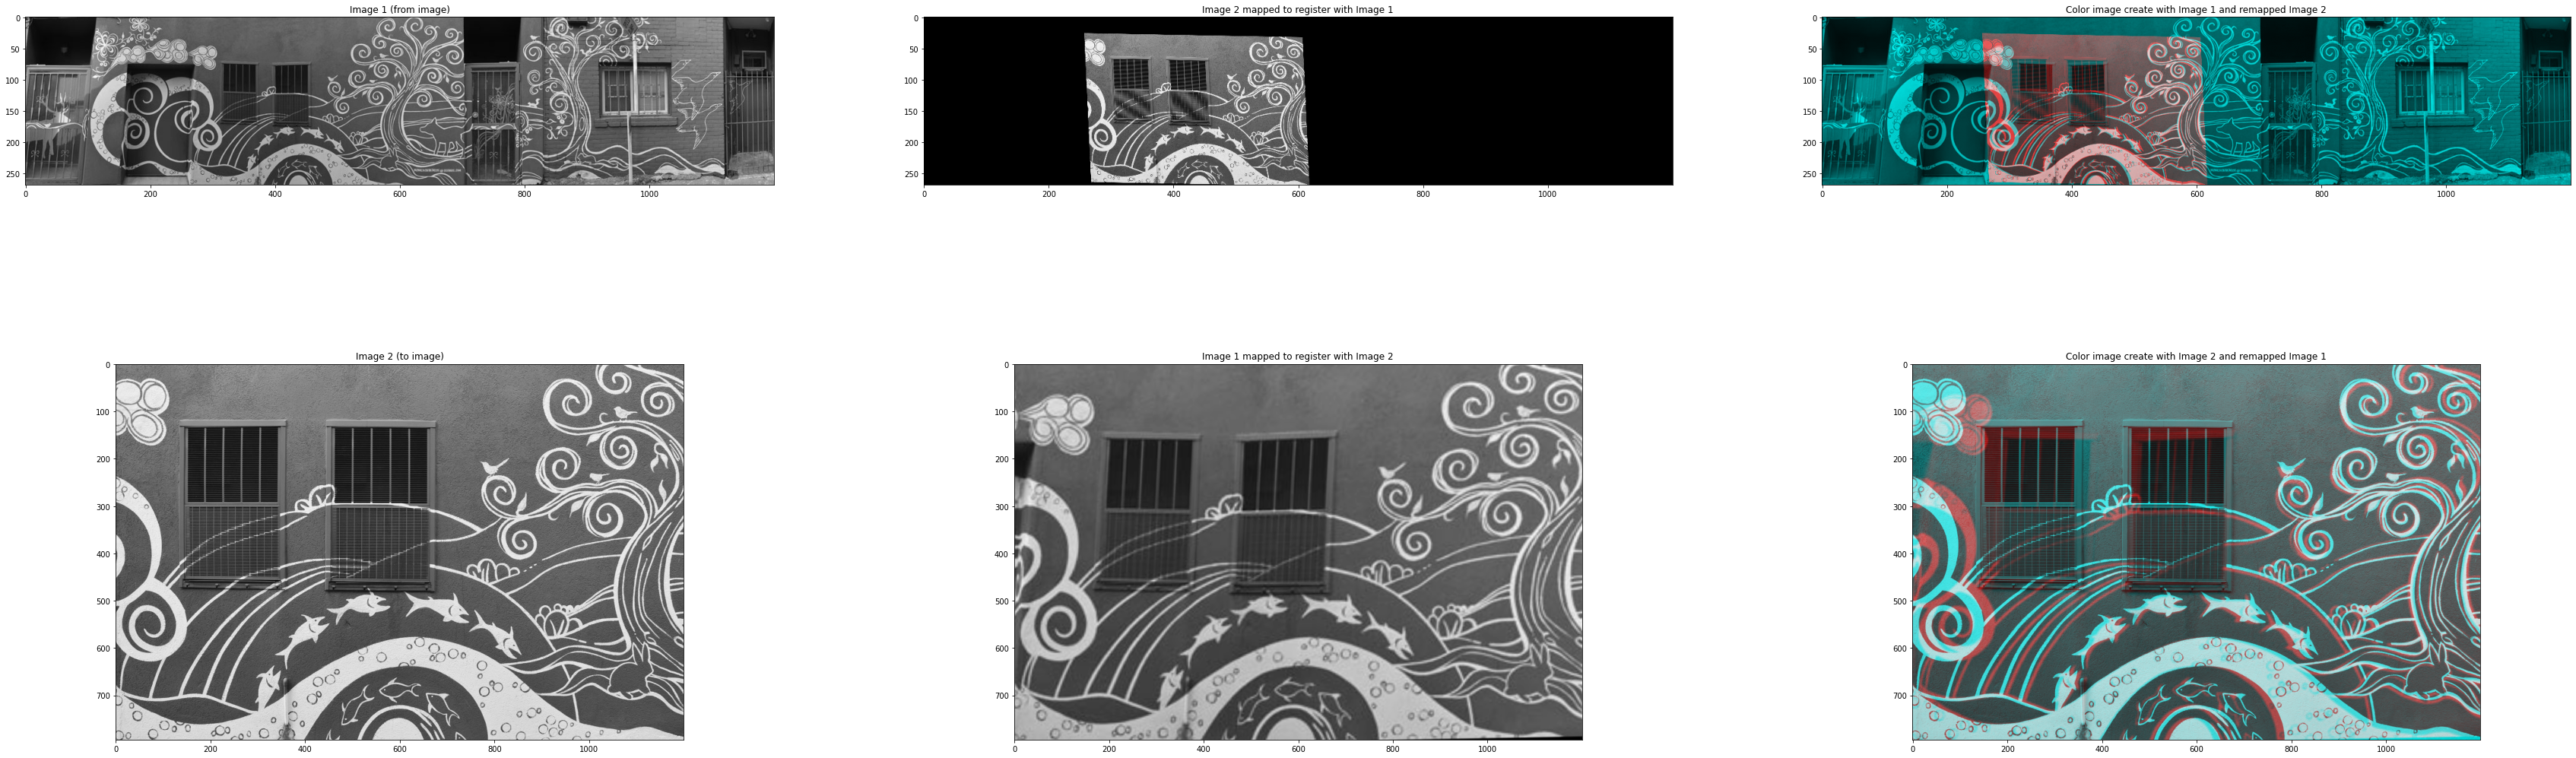

In [179]:
from skimage.transform import warp


warped_1_into_2 = warp(image_1, inverse_map=T_affine_inv, output_shape=image_2.shape)

warped_2_into_1 = warp(image_2, inverse_map=T_affine, output_shape=image_1.shape)

# build an RGB image with the registered images -- should be white if match is perfect
seq_im_1_into_2 = np.zeros((image_2.shape[0], image_2.shape[1], 3))
seq_im_1_into_2[..., 0] = warped_1_into_2
seq_im_1_into_2[..., 1] = image_2/255
seq_im_1_into_2[..., 2] = image_2/255

seq_im_2_into_1 = np.zeros((image_1.shape[0], image_1.shape[1], 3))
seq_im_2_into_1[..., 0] = warped_2_into_1
seq_im_2_into_1[..., 1] = image_1/255
seq_im_2_into_1[..., 2] = image_1/255


plt.figure(figsize = (60, 20))
plt.subplot(2,3,1)
plt.imshow(image_1, 'gray')
plt.title('Image 1 (from image)')

plt.subplot(2,3,2)
plt.imshow(warped_2_into_1, 'gray')
plt.title('Image 2 mapped to register with Image 1')

plt.subplot(2,3,3)
plt.imshow(seq_im_2_into_1, 'gray')
plt.title('Color image create with Image 1 and remapped Image 2')


plt.subplot(2,3,4)
plt.imshow(image_2, 'gray')
plt.title('Image 2 (to image)')

plt.subplot(2,3,5)
plt.imshow(warped_1_into_2, 'gray')
plt.title('Image 1 mapped to register with Image 2')

plt.subplot(2,3,6)
plt.imshow(seq_im_1_into_2, 'gray')
plt.title('Color image create with Image 2 and remapped Image 1')


# Jacobian for Similarity Transformation Estimation 

Like the affine transformation, the similarity transformation(compress and strech along x and y direction, plus translation) is linear with respect to its parameters. As a result, the single step estimation approach for affine estimation will work. The only difference will be in the Jacobian and consequently the Hessian matrices. The parameter vector is just four dimensional instead of six for affine transformation, i.e. 
$\mathbf{p} = 
\begin{bmatrix}
    t_x & t_y & a & b
\end{bmatrix}^T$. 

The Jacobian, corresponding to the $i$-the point, $\mathbf{J(x_i)}$ is given by
\begin{equation}
    \mathbf{J(\mathbf{x_i})} = \begin{bmatrix}
        1 & 0 & x_i & y_i \\
        0 & 1 & y_i & x_i
    \end{bmatrix}
\end{equation}

In terms of implementation, the only other difference will be in the choice of  constant matrices used to select coordinates from the point above to create the Jacobian. They would be the following for similarity transformation.
\begin{equation}
    \mathbf{P_1} = \begin{bmatrix}
        0 & 0 & 1 & 0 \\
        0 & 0 & 0 & 1 \\
        1 & 0 & 0 & 0 
    \end{bmatrix},
    \mathbf{P_2} = \begin{bmatrix}
        0 & 0 & 0 & 1\\
        0 & 0 & 1 & 0 \\
        0 & 1 & 0 & 0 
    \end{bmatrix} 
\end{equation}